In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# STEP 1 DATA UNDERSTANDING

In [4]:
df = pd.read_excel("stroke.xlsx", sheet_name="data")

In [5]:
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi  weight_in_kg  \
0        Private          Urban             228.69  36.6         116.0   
1  Self-employed          Rural             202.21   NaN          86.0   
2        Private          Rural             105.92  32.6          92.0   
3        Private          Urban             171.23  34.5          83.0   
4  Self-employed          Rural             174.12  24.0          63.0   

   height_in_m   smoking_status  stroke  
0         1.78  formerly smoked       1  
1         1.68     never smoked       1  
2         1.68     never smoked       1  
3         1.55           smokes       1  
4         1.62     never smoked       1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4914 non-null   float64
 10  weight_in_kg       4378 non-null   float64
 11  height_in_m        4378 non-null   float64
 12  smoking_status     5110 non-null   object 
 13  stroke             5110 non-null   int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 559.0+ KB


In [7]:
# Drop irrelevant features
df = df.drop(columns=['id', 'stroke'])


In [8]:
df.head()


gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi  weight_in_kg  height_in_m  \
0          Urban             228.69  36.6         116.0         1.78   
1          Rural             202.21   NaN          86.0         1.68   
2          Rural             105.92  32.6          92.0         1.68   
3          Urban             171.23  34.5          83.0         1.55   
4          Rural             174.12  24.0          63.0         1.62   

    smoking_status  
0  formerly smoked  
1     never smoked  
2     never smoked  
3           smokes  
4     never smoked

In [9]:
categorical_features = ['gender','hypertension', 'heart_disease', 'ever_married','smoking_status', 'work_type']

numerical_features = ['age', 'bmi', 'avg_glucose_level','weight_in_kg', 'height_in_m']


# STEP 2 DATA CLEANING

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  196
weight_in_kg         732
height_in_m          732
smoking_status         0
dtype: int64


<Axes: >

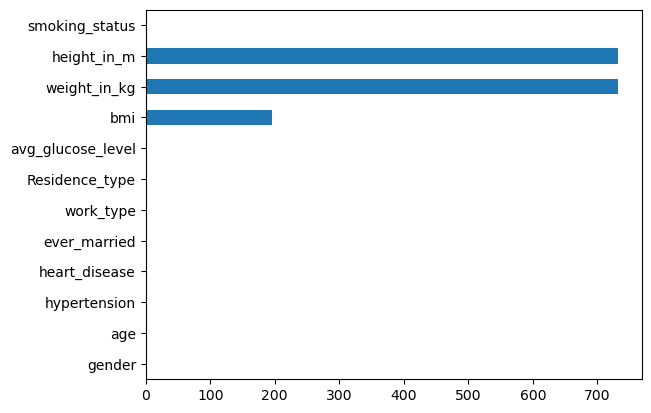

In [11]:
print(df.isna().sum())

df.isna().sum().plot.barh()

In [12]:
print("median of bmi",df['bmi'].median())


df['bmi']=df['bmi'].fillna(df['bmi'].median())




#fill the null of bmi using median

median of bmi 27.7


In [13]:
df['weight_in_kg']=df['weight_in_kg'].fillna(df['weight_in_kg'].median())
df['height_in_m']=df['height_in_m'].fillna(df['height_in_m'].median())


In [14]:
print(df.isna().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
weight_in_kg         0
height_in_m          0
smoking_status       0
dtype: int64


#cap the outliers

In [16]:

Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Define outlier criteria
outlier_condition = (df[numerical_features] < (Q1 - 1.5 * IQR)) | \
                    (df[numerical_features] > (Q3 + 1.5 * IQR))

# Determine which rows contain outliers (True/False)
outliers = outlier_condition.any(axis=1)

print(f"Number of outliers detected using IQR: {outliers.sum()}")

Number of outliers detected using IQR: 901


In [17]:
from scipy.stats import zscore

z_scores = df[numerical_features].apply(zscore)
no_outliers_mask = ((z_scores < 2)& (z_scores > -2)).all(axis=1)

cleaned_df = df[no_outliers_mask]

In [18]:
print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
df=cleaned_df

Original dataset size: 5110
Cleaned dataset size: 4112


In [19]:
#ensure cleaned_df replace df

print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")

Original dataset size: 4112
Cleaned dataset size: 4112


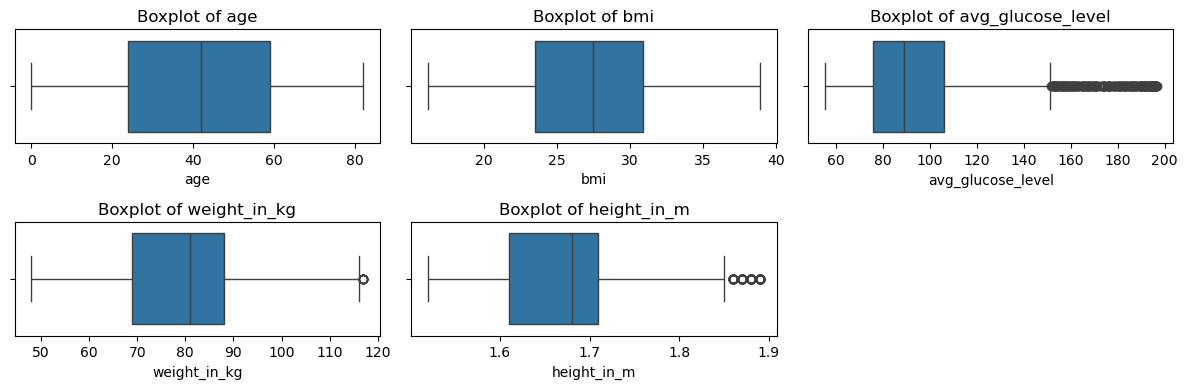

In [20]:

plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

Cap (Winsorize) to maintain sample size while reducing the impact of extreme values.

In [22]:
from scipy.stats.mstats import winsorize

df_capped = df.copy()
for feature in numerical_features:
    df_capped[feature] = winsorize(df_capped[feature], limits=[0.05, 0.05])

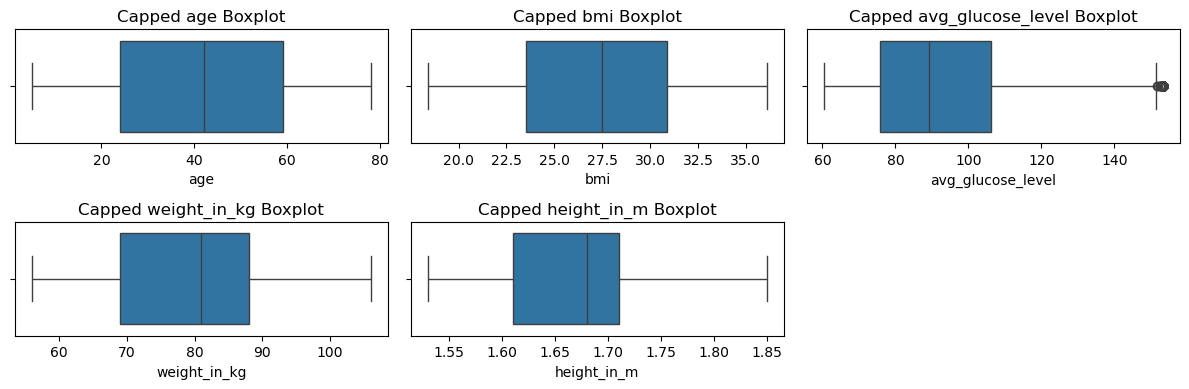

In [23]:
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df_capped[feature])
    plt.title(f"Capped {feature} Boxplot")
plt.tight_layout()
plt.show()


# STEP 3 DATA TRANSFORMATION

In [25]:
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   
5    Male  81.0             0              0          Yes        Private   
6    Male  74.0             1              1          Yes        Private   

  Residence_type  avg_glucose_level   bmi  weight_in_kg  height_in_m  \
2          Rural             105.92  32.6          92.0         1.68   
3          Urban             171.23  34.5          83.0         1.55   
4          Rural             174.12  24.0          63.0         1.62   
5          Urban             186.21  29.0          95.0         1.81   
6          Rural              70.09  27.4          84.0         1.75   

    smoking_status  
2     never smoked  
3           smokes  
4     never smoked  
5  formerly smoked  
6     never smoked

In [26]:
# data before scale

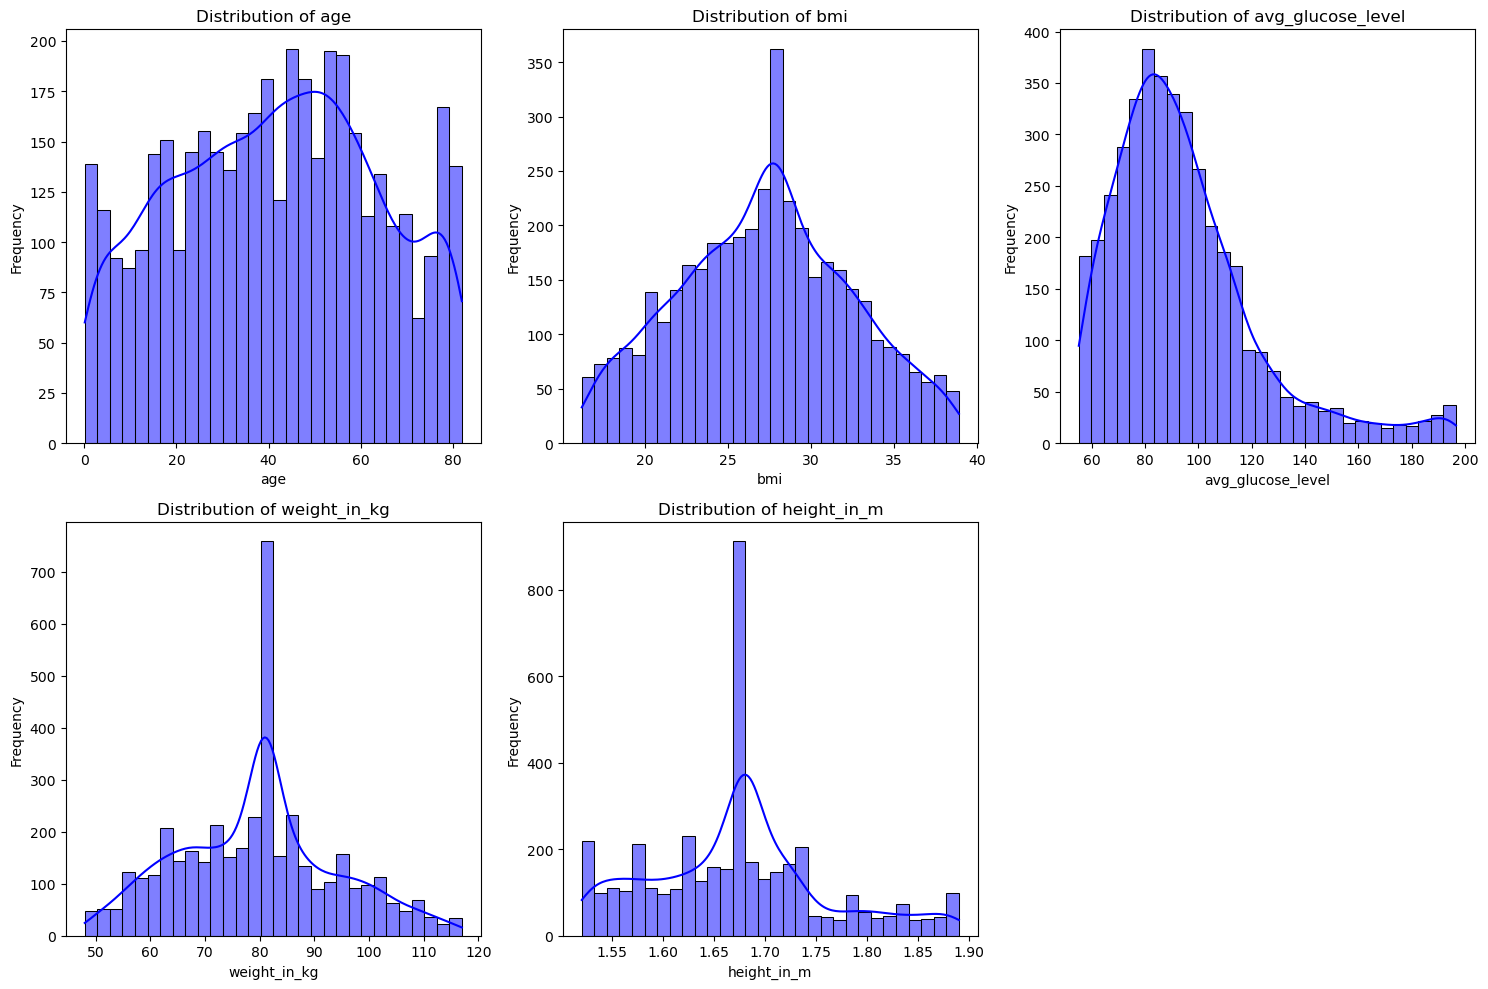

In [27]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='blue') 
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

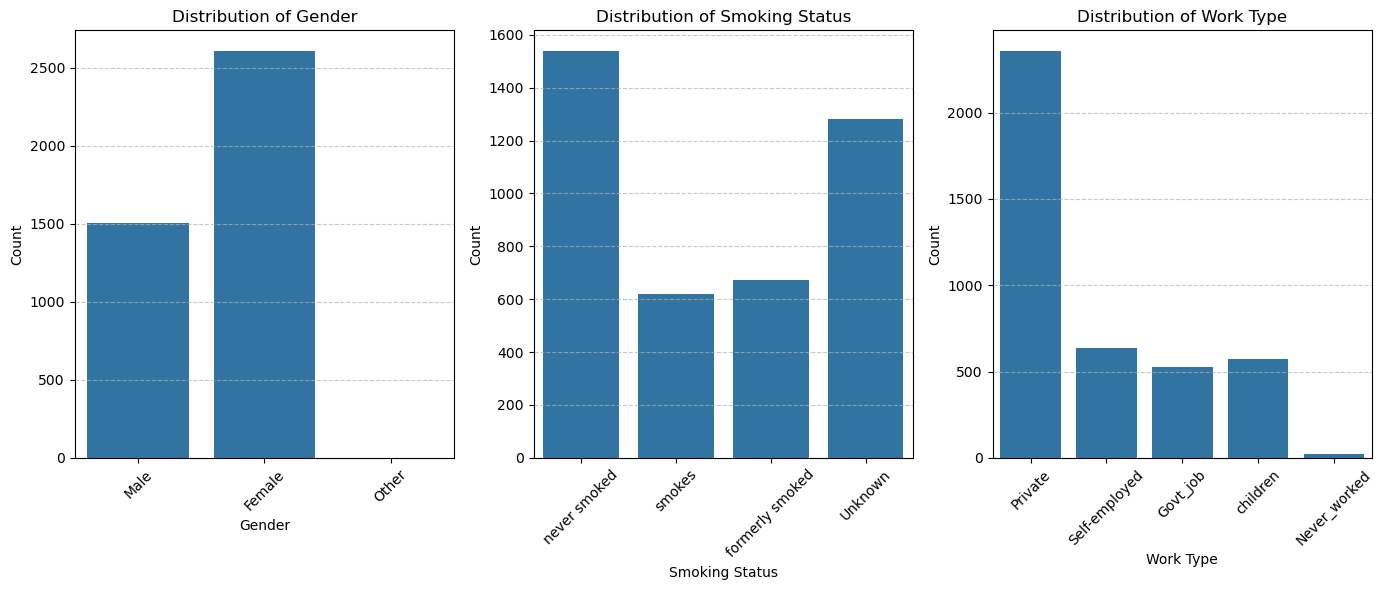

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Smoking status distribution
plt.subplot(1, 3, 2)  
sns.countplot(x='smoking_status', data=cleaned_df) 
plt.title('Distribution of Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Work type distribution
plt.subplot(1, 3, 3)  
sns.countplot(x='work_type', data=df) 
plt.title('Distribution of Work Type')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Gender distribution
plt.subplot(1, 3, 1) 
sns.countplot(x='gender', data=df) 
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [29]:
#NORMALIZED THE DATA ON THE SAME SCALE

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit and transform numerical features
df[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

# Verify scaling
print(df[numerical_features].head())


        age       bmi  avg_glucose_level  weight_in_kg  height_in_m
2  0.975586  0.722467           0.359036      0.637681     0.432432
3  0.597168  0.806167           0.820623      0.507246     0.081081
4  0.963379  0.343612           0.841049      0.217391     0.270270
5  0.987793  0.563877           0.926497      0.681159     0.783784
6  0.902344  0.493392           0.105803      0.521739     0.621622


In [31]:
print(cleaned_df.head())


   gender       age  hypertension  heart_disease ever_married      work_type  \
2    Male  0.975586             0              1          Yes        Private   
3  Female  0.597168             0              0          Yes        Private   
4  Female  0.963379             1              0          Yes  Self-employed   
5    Male  0.987793             0              0          Yes        Private   
6    Male  0.902344             1              1          Yes        Private   

  Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  \
2          Rural           0.359036  0.722467      0.637681     0.432432   
3          Urban           0.820623  0.806167      0.507246     0.081081   
4          Rural           0.841049  0.343612      0.217391     0.270270   
5          Urban           0.926497  0.563877      0.681159     0.783784   
6          Rural           0.105803  0.493392      0.521739     0.621622   

    smoking_status  
2     never smoked  
3           smokes  

In [32]:
df['work_type'].value_counts()

work_type
Private          2359
Self-employed     634
children          570
Govt_job          529
Never_worked       20
Name: count, dtype: int64

In [33]:
df['smoking_status'].value_counts()

smoking_status
never smoked       1540
Unknown            1280
formerly smoked     671
smokes              621
Name: count, dtype: int64

In [34]:
# Identify nominal categorical features
nominal_features = ['work_type', 'smoking_status']

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=nominal_features, drop_first=False)

# Verify encoding
print(df.head())


   gender       age  hypertension  heart_disease ever_married Residence_type  \
2    Male  0.975586             0              1          Yes          Rural   
3  Female  0.597168             0              0          Yes          Urban   
4  Female  0.963379             1              0          Yes          Rural   
5    Male  0.987793             0              0          Yes          Urban   
6    Male  0.902344             1              1          Yes          Rural   

   avg_glucose_level       bmi  weight_in_kg  height_in_m  work_type_Govt_job  \
2           0.359036  0.722467      0.637681     0.432432               False   
3           0.820623  0.806167      0.507246     0.081081               False   
4           0.841049  0.343612      0.217391     0.270270               False   
5           0.926497  0.563877      0.681159     0.783784               False   
6           0.105803  0.493392      0.521739     0.621622               False   

   work_type_Never_worked  work_

In [35]:
df['Residence_type'].value_counts()

Residence_type
Urban    2092
Rural    2020
Name: count, dtype: int64

In [36]:
df['gender'].value_counts()

gender
Female    2608
Male      1503
Other        1
Name: count, dtype: int64

In [37]:
# Encode to binary
df['gender'] = df['gender'].map({'Other':2 ,'Male': 1, 'Female': 0})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# Verify conversion
print(df['ever_married'].head())

print(df['Residence_type'].head())


2    1
3    1
4    1
5    1
6    1
Name: ever_married, dtype: int64
2    0
3    1
4    0
5    1
6    0
Name: Residence_type, dtype: int64


In [38]:
df['Residence_type'].value_counts()

Residence_type
1    2092
0    2020
Name: count, dtype: int64

In [39]:
# List non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: []


gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
weight_in_kg                      0
height_in_m                       0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


<Axes: >

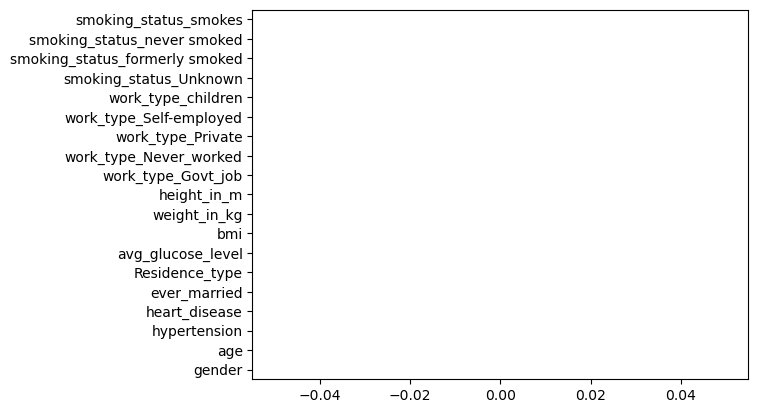

In [40]:
print(df.isna().sum())

df.isna().sum().plot.barh()

# STEP 4 Dimensionality Reduction PCA

In [42]:
df.head()

gender       age  hypertension  heart_disease  ever_married  \
2       1  0.975586             0              1             1   
3       0  0.597168             0              0             1   
4       0  0.963379             1              0             1   
5       1  0.987793             0              0             1   
6       1  0.902344             1              1             1   

   Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  \
2               0           0.359036  0.722467      0.637681     0.432432   
3               1           0.820623  0.806167      0.507246     0.081081   
4               0           0.841049  0.343612      0.217391     0.270270   
5               1           0.926497  0.563877      0.681159     0.783784   
6               0           0.105803  0.493392      0.521739     0.621622   

   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
2               False                   False               True   
3               False                   False               True   
4               False                   False              False   
5               False                   False               True   
6               False                   False               True   

   work_type_Self-employed  work_type_children  smoking_status_Unknown  \
2                    False               False                   False   
3                    False               False                   False   
4                     True               False                   False   
5                    False               False                   False   
6                    False               False                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
2                           False                         True   
3                           False                        False   
4                           False                         True   
5                            True                        False   
6                           False                         True   

   smoking_status_smokes  
2                  False  
3                   True  
4                  False  
5                  False  
6                  False

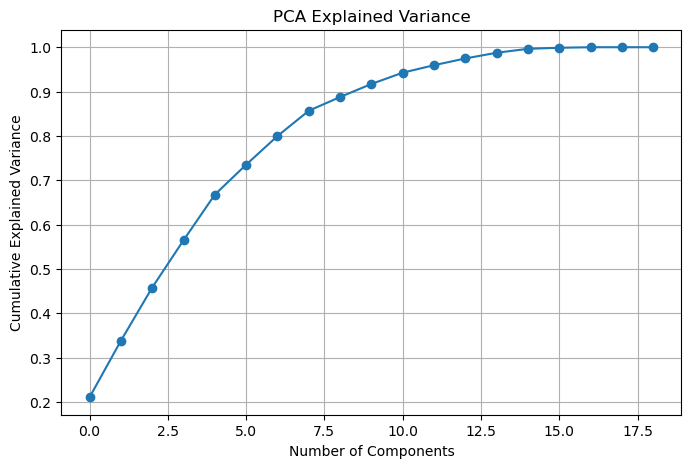

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA()
pca.fit(df) 

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


In [44]:
pca = PCA(n_components=0.90)  
reduced_data = pca.fit_transform(df)  

reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])
print(reduced_df.head()) 

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.773394  0.262951 -0.107179  0.943435 -0.290657  0.351607 -0.082914   
1 -0.582754  0.169241 -0.505401 -0.708380  0.357681 -0.358842 -0.598790   
2 -0.635630 -0.846823  0.811115  0.121429 -0.559599  0.278004 -0.001963   
3 -0.475178 -0.122979 -1.109699  0.322462  0.478408  0.000039  0.670423   
4 -0.782548  0.215852 -0.116757  0.990677 -0.288559  0.335174 -0.075386   

        PC8       PC9      PC10  
0  0.004283 -0.011453  0.040435  
1 -0.199483  0.068705  0.049826  
2 -0.637440 -0.243700  0.773225  
3  0.201161  0.074375  0.029975  
4 -0.063330 -0.292914  0.882224  


In [45]:
df.head()

gender       age  hypertension  heart_disease  ever_married  \
2       1  0.975586             0              1             1   
3       0  0.597168             0              0             1   
4       0  0.963379             1              0             1   
5       1  0.987793             0              0             1   
6       1  0.902344             1              1             1   

   Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  \
2               0           0.359036  0.722467      0.637681     0.432432   
3               1           0.820623  0.806167      0.507246     0.081081   
4               0           0.841049  0.343612      0.217391     0.270270   
5               1           0.926497  0.563877      0.681159     0.783784   
6               0           0.105803  0.493392      0.521739     0.621622   

   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
2               False                   False               True   
3               False                   False               True   
4               False                   False              False   
5               False                   False               True   
6               False                   False               True   

   work_type_Self-employed  work_type_children  smoking_status_Unknown  \
2                    False               False                   False   
3                    False               False                   False   
4                     True               False                   False   
5                    False               False                   False   
6                    False               False                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
2                           False                         True   
3                           False                        False   
4                           False                         True   
5                            True                        False   
6                           False                         True   

   smoking_status_smokes  
2                  False  
3                   True  
4                  False  
5                  False  
6                  False

In [46]:
all_features= ['gender',
                  'age',
                  'hypertension',
                  'heart_disease',
                  'ever_married',	'Residence_type',	'avg_glucose_level',	'bmi',	'weight_in_kg',	'height_in_m',	'work_type_Govt_job','work_type_Never_worked',
                  'work_type_Private',
                  'work_type_Self-employed',	'work_type_children','smoking_status_Unknown',
                  'smoking_status_formerly smoked',	'smoking_status_never smoked',	'smoking_status_smokes']

loadings = pd.DataFrame(
    pca.components_,
    columns=all_features,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
print(loadings)


        gender       age  hypertension  heart_disease  ever_married  \
PC1   0.161181 -0.249239     -0.072835      -0.026695     -0.462138   
PC2  -0.036499 -0.197885     -0.076217      -0.047759     -0.338773   
PC3  -0.405232 -0.113074     -0.021978      -0.041243     -0.264945   
PC4   0.780755 -0.019731      0.024614       0.035213     -0.065148   
PC5   0.164236 -0.035109     -0.010890      -0.003983     -0.077399   
PC6   0.007553  0.147499      0.012957       0.011113      0.447563   
PC7  -0.030601 -0.016778     -0.003906       0.002653     -0.207349   
PC8   0.000420 -0.026115     -0.064526      -0.040916      0.158262   
PC9   0.065335 -0.170641     -0.420046      -0.082844      0.495638   
PC10 -0.027746  0.035001      0.849187       0.074731      0.144868   

      Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  \
PC1        -0.005215          -0.010658 -0.159011      0.001669     0.034333   
PC2        -0.112717          -0.013892 -0.042977     -0.0

In [47]:
print(pca.components_.shape)  # (n_components, n_features)
print(len(all_features))  

(10, 19)
19


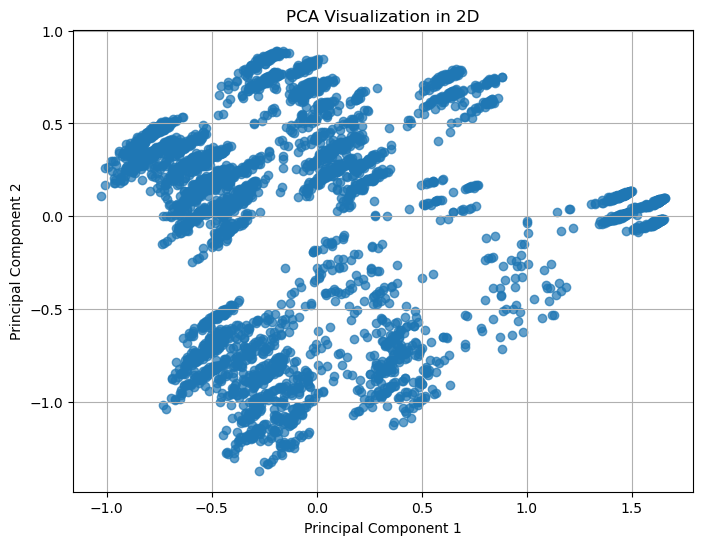

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization in 2D')
plt.grid()
plt.show()


# STEP 5 EDA

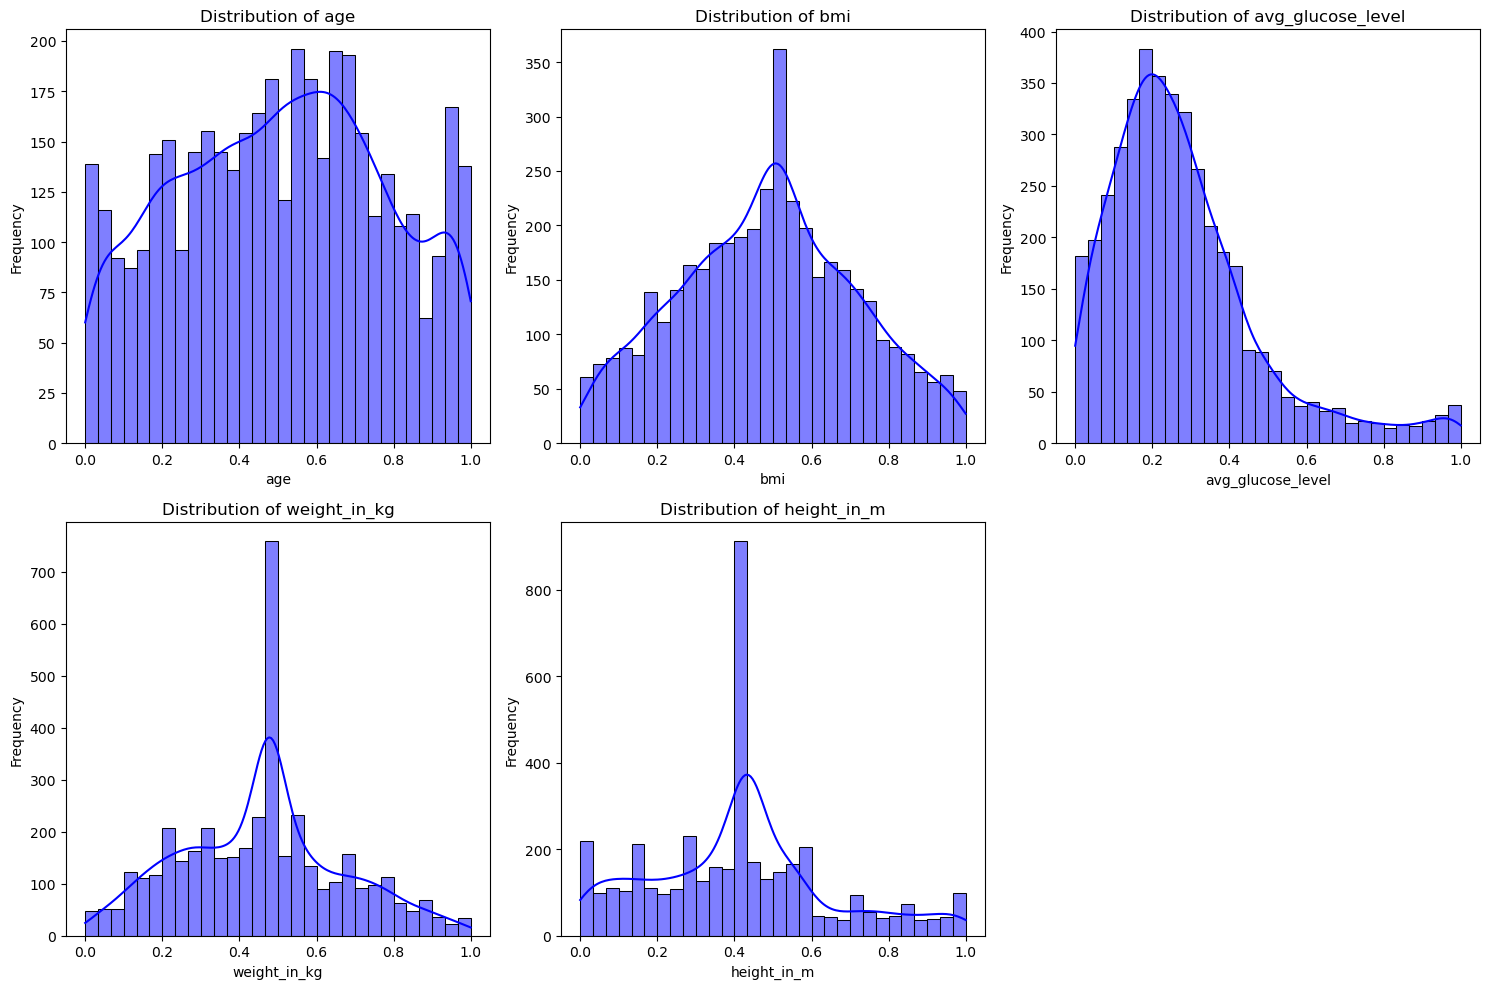

In [50]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='blue') 
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

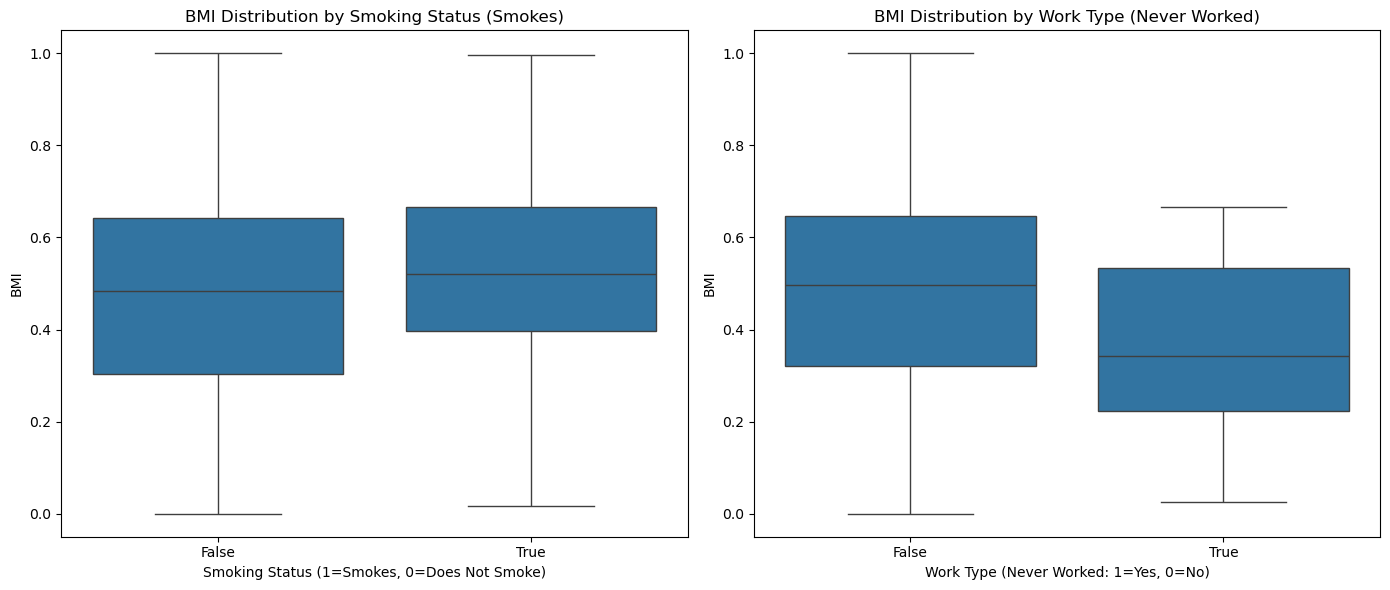

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Boxplot for smoking status vs. BMI
sns.boxplot(x=df['smoking_status_smokes'], y=df['bmi'], ax=axes[0])
axes[0].set_title('BMI Distribution by Smoking Status (Smokes)')
axes[0].set_xlabel('Smoking Status (1=Smokes, 0=Does Not Smoke)')
axes[0].set_ylabel('BMI')

# Boxplot for work type (Never Worked) vs. BMI
sns.boxplot(x=df['work_type_Never_worked'], y=df['bmi'], ax=axes[1])
axes[1].set_title('BMI Distribution by Work Type (Never Worked)')
axes[1].set_xlabel('Work Type (Never Worked: 1=Yes, 0=No)')
axes[1].set_ylabel('BMI')

# Adjust layout
plt.tight_layout()
plt.show()


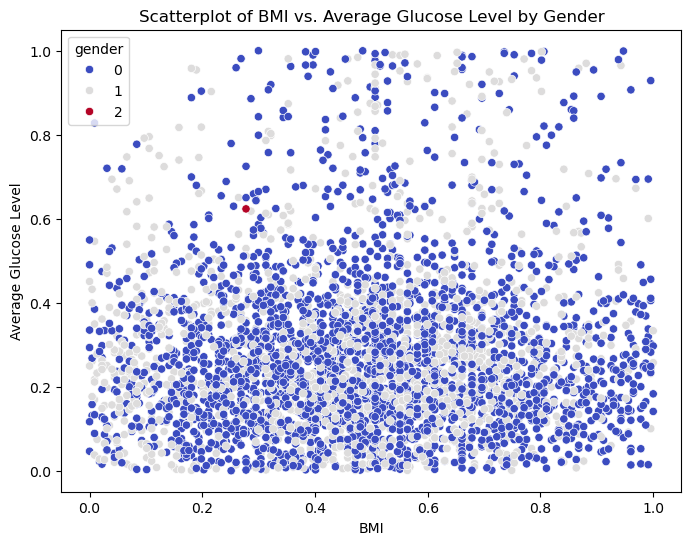

In [52]:
# Scatterplot between two key variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='avg_glucose_level', hue='gender', data=df, palette='coolwarm')
plt.title('Scatterplot of BMI vs. Average Glucose Level by Gender')
plt.xlabel('BMI')
plt.ylabel('Average Glucose Level')
plt.show()


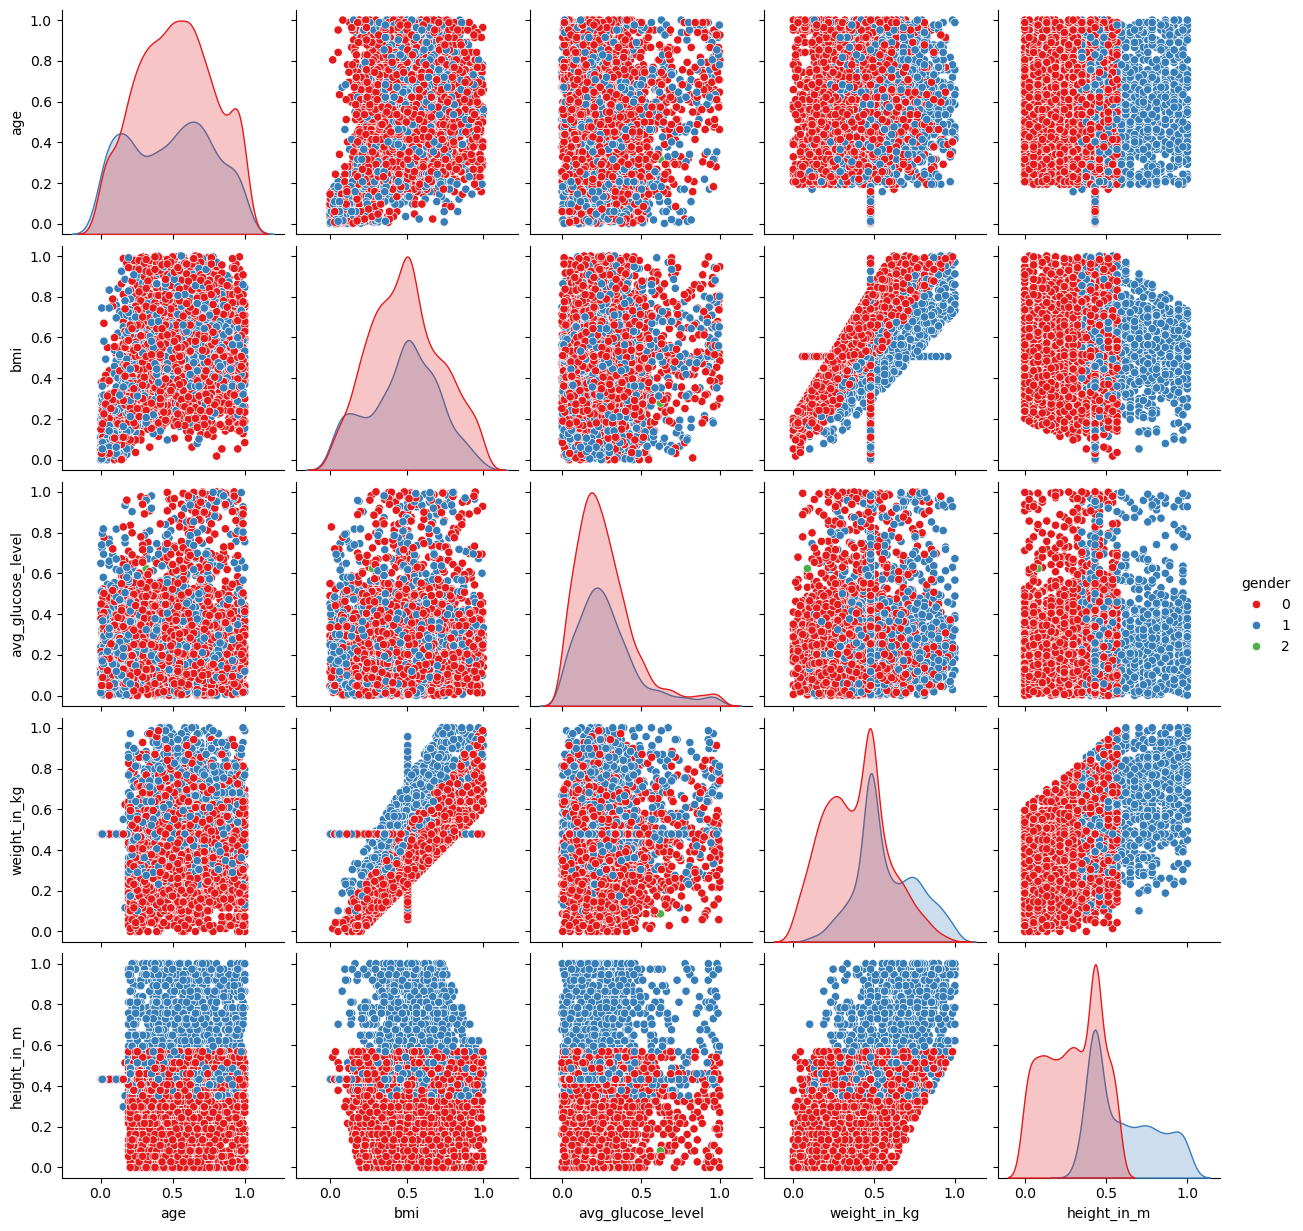

In [53]:
# Pairplot to visualize relationships between all numerical features
sns.pairplot(df[numerical_features + ['gender']], hue='gender', palette='Set1', diag_kind='kde')
plt.show()


#df['gender']            ({'Other':2 ,'Male': 1, 'Female': 0})
#df['ever_married']      ({'Yes': 1, 'No': 0})
#df['Residence_type']    ({'Urban': 1, 'Rural': 0})


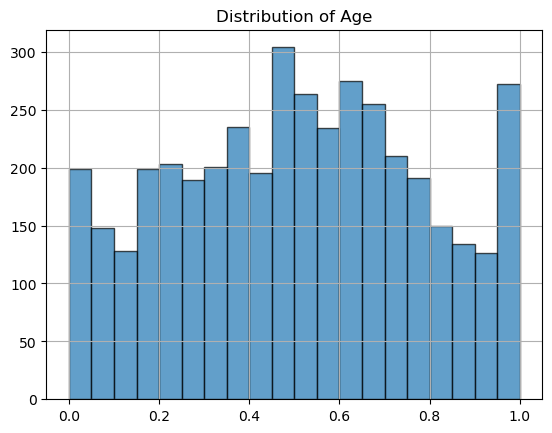

In [54]:
#  Basic Distributions
df['age'].hist(bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of Age')
plt.show()

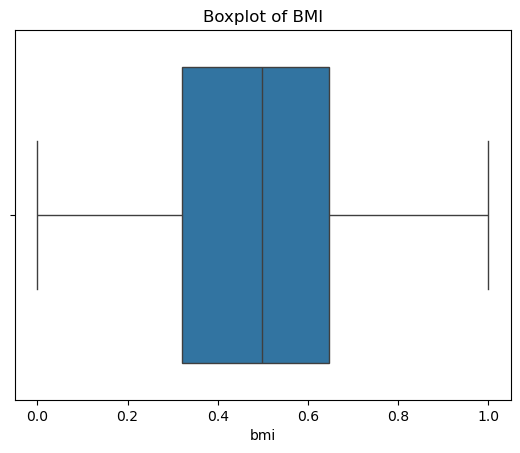

In [55]:
#  Boxplot of BMI
sns.boxplot(x=df['bmi'])
plt.title('Boxplot of BMI')
plt.show()


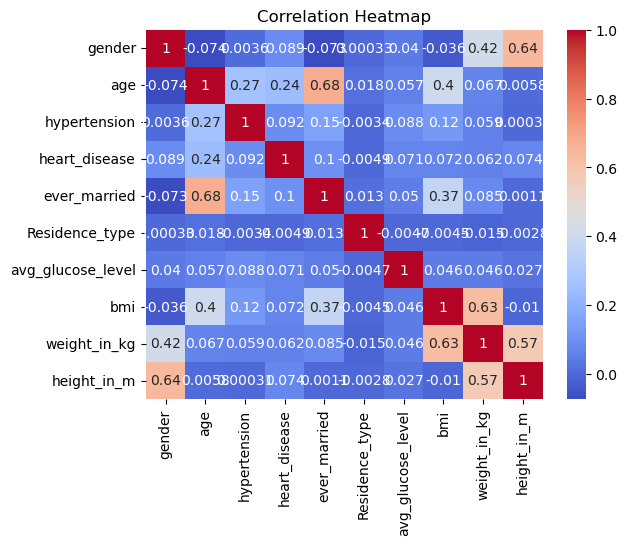

In [56]:
# Correlation Heatmap
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

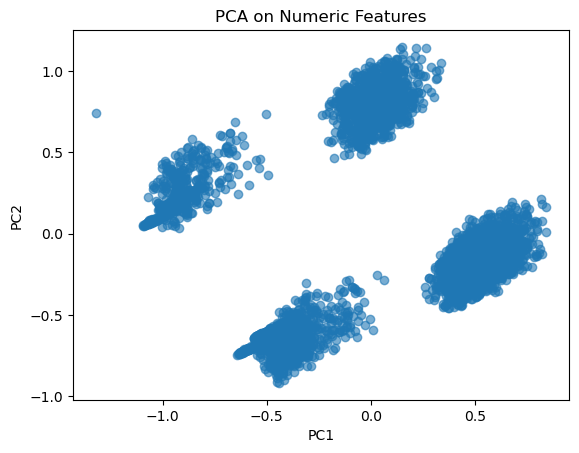

In [57]:
# PCA Visualization
numeric_df = df.select_dtypes(include=[np.number]).dropna()
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(numeric_df)
df_pca = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'])
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.6)
plt.title('PCA on Numeric Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

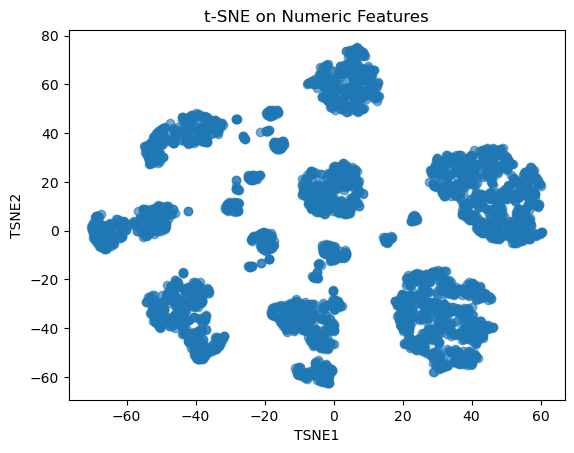

In [58]:
from sklearn.manifold import TSNE

#  t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(numeric_df)
df_tsne = pd.DataFrame(tsne_coords, columns=['TSNE1', 'TSNE2'])
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], alpha=0.6)
plt.title('t-SNE on Numeric Features')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

In [59]:
numeric_df

gender       age  hypertension  heart_disease  ever_married  \
2          1  0.975586             0              1             1   
3          0  0.597168             0              0             1   
4          0  0.963379             1              0             1   
5          1  0.987793             0              0             1   
6          1  0.902344             1              1             1   
...      ...       ...           ...            ...           ...   
5104       0  0.157715             0              0             0   
5105       0  0.975586             1              0             1   
5107       0  0.426270             0              0             1   
5108       1  0.621582             0              0             1   
5109       0  0.536133             0              0             1   

      Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  
2                  0           0.359036  0.722467      0.637681     0.432432  
3                  1           0.820623  0.806167      0.507246     0.081081  
4                  0           0.841049  0.343612      0.217391     0.270270  
5                  1           0.926497  0.563877      0.681159     0.783784  
6                  0           0.105803  0.493392      0.521739     0.621622  
...              ...                ...       ...           ...          ...  
5104               0           0.338964  0.110132      0.478261     0.432432  
5105               1           0.202346  0.506608      0.144928     0.081081  
5107               0           0.196975  0.643172      0.347826     0.027027  
5108               0           0.785709  0.418502      0.565217     0.864865  
5109               1           0.213160  0.436123      0.333333     0.351351  

[4112 rows x 10 columns]

# STEP 6 k-MEANS AS CLUSTERING ALGORITHM

In [61]:
df.head()

gender       age  hypertension  heart_disease  ever_married  \
2       1  0.975586             0              1             1   
3       0  0.597168             0              0             1   
4       0  0.963379             1              0             1   
5       1  0.987793             0              0             1   
6       1  0.902344             1              1             1   

   Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  \
2               0           0.359036  0.722467      0.637681     0.432432   
3               1           0.820623  0.806167      0.507246     0.081081   
4               0           0.841049  0.343612      0.217391     0.270270   
5               1           0.926497  0.563877      0.681159     0.783784   
6               0           0.105803  0.493392      0.521739     0.621622   

   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
2               False                   False               True   
3               False                   False               True   
4               False                   False              False   
5               False                   False               True   
6               False                   False               True   

   work_type_Self-employed  work_type_children  smoking_status_Unknown  \
2                    False               False                   False   
3                    False               False                   False   
4                     True               False                   False   
5                    False               False                   False   
6                    False               False                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
2                           False                         True   
3                           False                        False   
4                           False                         True   
5                            True                        False   
6                           False                         True   

   smoking_status_smokes  
2                  False  
3                   True  
4                  False  
5                  False  
6                  False

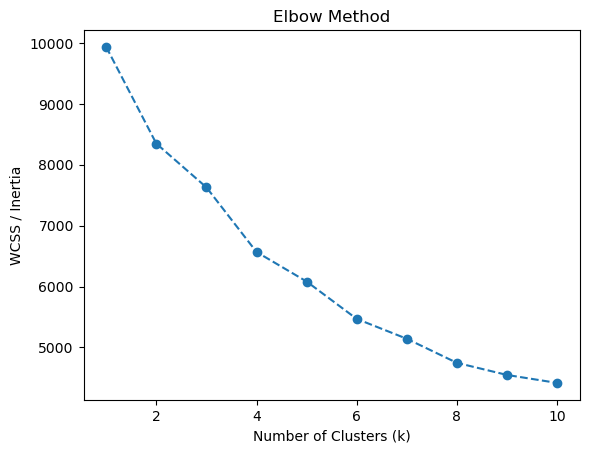

In [62]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(df) 
    wcss.append(kmeans.inertia_)

plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS / Inertia')
plt.show()

In [63]:
reduced_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.773394  0.262951 -0.107179  0.943435 -0.290657  0.351607 -0.082914   
1 -0.582754  0.169241 -0.505401 -0.708380  0.357681 -0.358842 -0.598790   
2 -0.635630 -0.846823  0.811115  0.121429 -0.559599  0.278004 -0.001963   
3 -0.475178 -0.122979 -1.109699  0.322462  0.478408  0.000039  0.670423   
4 -0.782548  0.215852 -0.116757  0.990677 -0.288559  0.335174 -0.075386   

        PC8       PC9      PC10  
0  0.004283 -0.011453  0.040435  
1 -0.199483  0.068705  0.049826  
2 -0.637440 -0.243700  0.773225  
3  0.201161  0.074375  0.029975  
4 -0.063330 -0.292914  0.882224

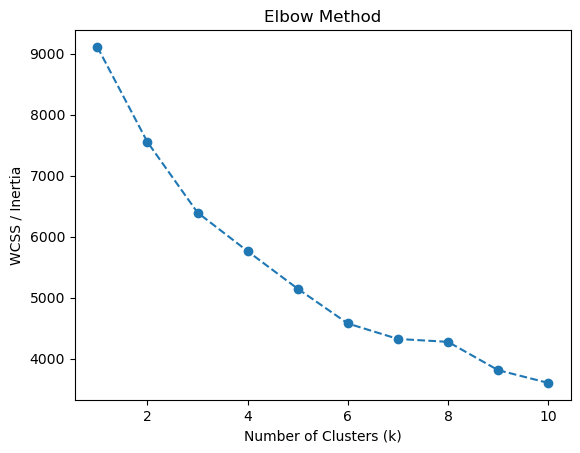

In [64]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(reduced_df) 
    wcss.append(kmeans.inertia_)

plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS / Inertia')
plt.show()

# STEP 7 BUILD THE MODEL

In [66]:
from sklearn.metrics import silhouette_score

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)
    score = silhouette_score(df, labels)
    print(f'k={k}, Silhouette Score={score:.4f}')


k=2, Silhouette Score=0.1874
k=3, Silhouette Score=0.1485
k=4, Silhouette Score=0.1855
k=5, Silhouette Score=0.2099
k=6, Silhouette Score=0.2270
k=7, Silhouette Score=0.2339
k=8, Silhouette Score=0.2219
k=9, Silhouette Score=0.2157
k=10, Silhouette Score=0.2100
k=11, Silhouette Score=0.2270
k=12, Silhouette Score=0.2311
k=13, Silhouette Score=0.2338
k=14, Silhouette Score=0.2451


In [67]:
from sklearn.metrics import silhouette_score

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_df)
    score = silhouette_score(reduced_data, labels)
    print(f'k={k}, Silhouette Score={score:.4f}')


k=2, Silhouette Score=0.1999
k=3, Silhouette Score=0.2213
k=4, Silhouette Score=0.2081
k=5, Silhouette Score=0.2425
k=6, Silhouette Score=0.2837
k=7, Silhouette Score=0.2566
k=8, Silhouette Score=0.2542
k=9, Silhouette Score=0.2877
k=10, Silhouette Score=0.3052
k=11, Silhouette Score=0.2966
k=12, Silhouette Score=0.2973
k=13, Silhouette Score=0.3091
k=14, Silhouette Score=0.3101


In [68]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df['Cluster'] = kmeans.fit_predict(reduced_data)  
original_features = df.drop(columns=['Cluster'])

sil_score = silhouette_score(original_features, df['Cluster'])
print(f'Final Silhouette Score non PCA: {sil_score:.4f}')
sil_score_pca = silhouette_score(reduced_df, df['Cluster'])
print(f'Final Silhouette Score PCA: {sil_score_pca:.4f}')

Final Silhouette Score non PCA: 0.2122
Final Silhouette Score PCA: 0.2425


# STEP 8 CLUSTER EVALUATION

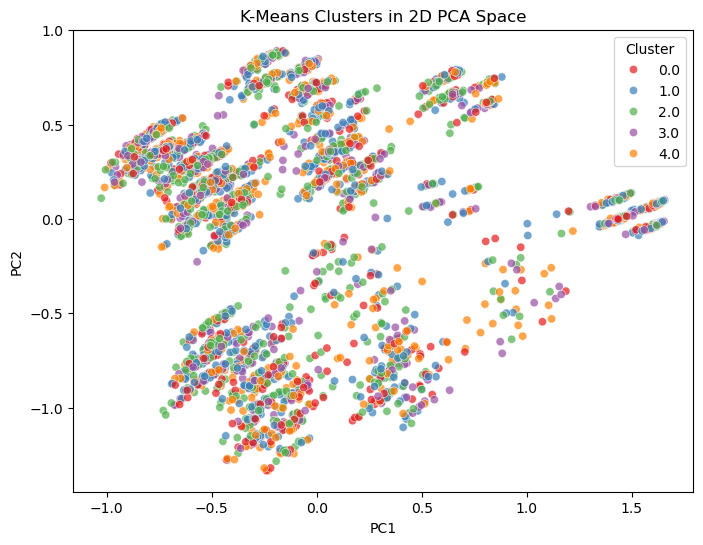

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df.drop('Cluster', axis=1))

import matplotlib.pyplot as plt
import seaborn as sns

df_pca = pd.DataFrame(pca_features, columns=['PC1','PC2'])
df_pca['Cluster'] = df['Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Cluster', 
    data=df_pca, 
    palette='Set1', alpha=0.7
)
plt.title('K-Means Clusters in 2D PCA Space')
plt.show()


<Axes: xlabel='Cluster', ylabel='bmi'>

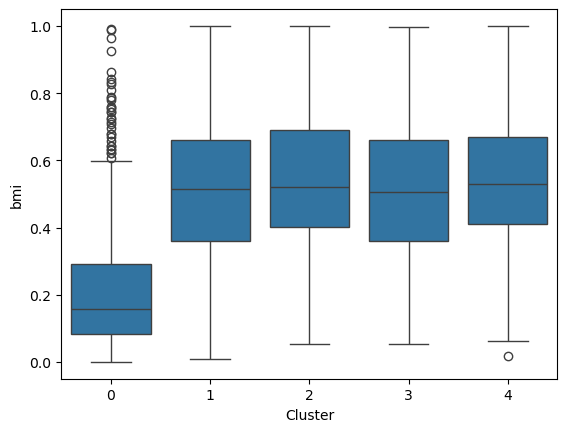

In [71]:
import seaborn as sns
sns.boxplot(x='Cluster', y='bmi', data=df)


In [72]:
import pandas as pd
from sklearn.decomposition import PCA

# Suppose 'df' is your numeric dataset (after encoding and/or scaling if necessary)
pca_3 = PCA(n_components=3)
pca_features_3 = pca_3.fit_transform(df)

# Convert the resulting array to a DataFrame
df_pca_3 = pd.DataFrame(
    data=pca_features_3, 
    columns=['PC1', 'PC2', 'PC3']
)

print("Explained Variance Ratio of 3 PCs:", pca_3.explained_variance_ratio_)
print("Sum of Explained Variance:", pca_3.explained_variance_ratio_.sum())
df_pca_3.head()


Explained Variance Ratio of 3 PCs: [0.48679928 0.10875851 0.07292861]
Sum of Explained Variance: 0.6684864038373675


PC1       PC2       PC3
0 -0.856956  0.919900  0.263332
1  2.173535  0.049125  0.167305
2 -0.084237  0.866855 -0.844215
3  2.161487 -0.101182 -0.126236
4 -0.862102  0.934148  0.216233

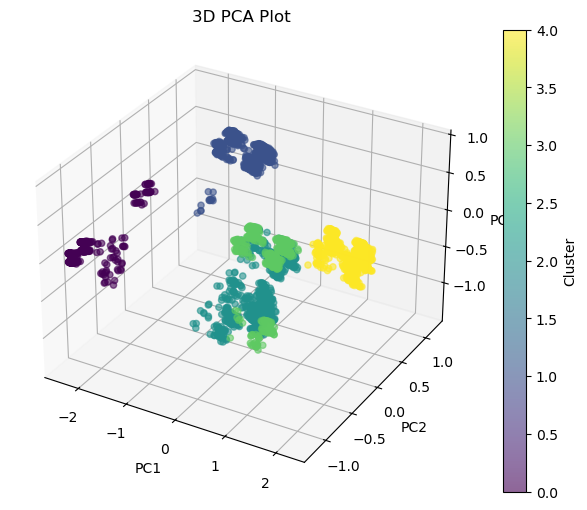

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sns



fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
sc = ax.scatter(
    df_pca_3['PC1'], 
    df_pca_3['PC2'], 
    df_pca_3['PC3'], 
    c=df['Cluster'] if 'Cluster' in df.columns else None, 
    cmap='viridis', 
    alpha=0.6
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Plot')


if 'Cluster' in df.columns:
    plt.colorbar(sc, label='Cluster')

plt.show()


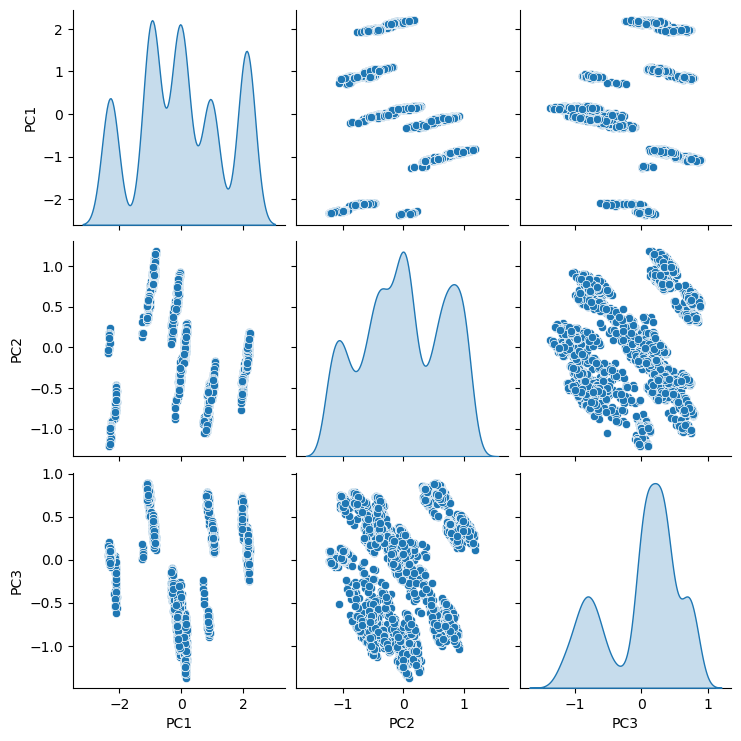

In [74]:
import seaborn as sns
sns.pairplot(df_pca_3, diag_kind='kde')


In [75]:
df.groupby('Cluster').mean()


gender       age  hypertension  heart_disease  ever_married  \
Cluster                                                                  
0        0.538079  0.096863      0.000000       0.001656      0.000000   
1        0.310757  0.507366      0.083665       0.033865      0.657371   
2        0.326296  0.679571      0.135317       0.072937      0.851248   
3        0.341977  0.524460      0.030794       0.017828      0.677472   
4        0.375148  0.574502      0.099408       0.057988      0.770414   

         Residence_type  avg_glucose_level       bmi  weight_in_kg  \
Cluster                                                              
0              0.498344           0.269063  0.212664      0.472646   
1              0.507968           0.281069  0.521912      0.444699   
2              0.524952           0.285118  0.544488      0.457426   
3              0.505673           0.277254  0.516311      0.441923   
4              0.499408           0.275537  0.543706      0.469154   

         height_in_m  work_type_Govt_job  work_type_Never_worked  \
Cluster                                                            
0           0.435430            0.018212                0.011589   
1           0.404544            0.000000                0.012948   
2           0.397832            0.406910                0.000000   
3           0.407552            0.152350                0.000000   
4           0.421206            0.000000                0.000000   

         work_type_Private  work_type_Self-employed  work_type_children  \
Cluster                                                                   
0                 0.000000                  0.02649            0.943709   
1                 0.987052                  0.00000            0.000000   
2                 0.000000                  0.59309            0.000000   
3                 0.847650                  0.00000            0.000000   
4                 1.000000                  0.00000            0.000000   

         smoking_status_Unknown  smoking_status_formerly smoked  \
Cluster                                                           
0                      0.899007                        0.018212   
1                      0.000000                        0.000000   
2                      0.115163                        0.242802   
3                      1.000000                        0.000000   
4                      0.000000                        0.481657   

         smoking_status_never smoked  smoking_status_smokes  
Cluster                                                      
0                           0.081126               0.001656  
1                           1.000000               0.000000  
2                           0.467370               0.174664  
3                           0.000000               0.000000  
4                           0.000000               0.518343

In [76]:
df.head()

gender       age  hypertension  heart_disease  ever_married  \
2       1  0.975586             0              1             1   
3       0  0.597168             0              0             1   
4       0  0.963379             1              0             1   
5       1  0.987793             0              0             1   
6       1  0.902344             1              1             1   

   Residence_type  avg_glucose_level       bmi  weight_in_kg  height_in_m  \
2               0           0.359036  0.722467      0.637681     0.432432   
3               1           0.820623  0.806167      0.507246     0.081081   
4               0           0.841049  0.343612      0.217391     0.270270   
5               1           0.926497  0.563877      0.681159     0.783784   
6               0           0.105803  0.493392      0.521739     0.621622   

   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
2               False                   False               True   
3               False                   False               True   
4               False                   False              False   
5               False                   False               True   
6               False                   False               True   

   work_type_Self-employed  work_type_children  smoking_status_Unknown  \
2                    False               False                   False   
3                    False               False                   False   
4                     True               False                   False   
5                    False               False                   False   
6                    False               False                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
2                           False                         True   
3                           False                        False   
4                           False                         True   
5                            True                        False   
6                           False                         True   

   smoking_status_smokes  Cluster  
2                  False        1  
3                   True        4  
4                  False        2  
5                  False        4  
6                  False        1

drop cluster for score

In [78]:
# Convert scaled data back to the original scale
unscaled_data = minmax_scaler.inverse_transform(df[numerical_features])

# Convert back to a DataFrame for visualization
unscaled_df = pd.DataFrame(unscaled_data, columns=numerical_features)

print("Unscaled Data:")
print(unscaled_df)


Unscaled Data:
       age   bmi  avg_glucose_level  weight_in_kg  height_in_m
0     80.0  32.6             105.92          92.0         1.68
1     49.0  34.5             171.23          83.0         1.55
2     79.0  24.0             174.12          63.0         1.62
3     81.0  29.0             186.21          95.0         1.81
4     74.0  27.4              70.09          84.0         1.75
...    ...   ...                ...           ...          ...
4107  13.0  18.7             103.08          81.0         1.68
4108  80.0  27.7              83.75          58.0         1.55
4109  35.0  30.8              82.99          72.0         1.53
4110  51.0  25.7             166.29          87.0         1.84
4111  44.0  26.1              85.28          71.0         1.65

[4112 rows x 5 columns]


# Result

In [80]:
# Group by Cluster and calculate means
cluster_means = df.groupby('Cluster').mean()

# Preview the data
print(cluster_means)


           gender       age  hypertension  heart_disease  ever_married  \
Cluster                                                                  
0        0.538079  0.096863      0.000000       0.001656      0.000000   
1        0.310757  0.507366      0.083665       0.033865      0.657371   
2        0.326296  0.679571      0.135317       0.072937      0.851248   
3        0.341977  0.524460      0.030794       0.017828      0.677472   
4        0.375148  0.574502      0.099408       0.057988      0.770414   

         Residence_type  avg_glucose_level       bmi  weight_in_kg  \
Cluster                                                              
0              0.498344           0.269063  0.212664      0.472646   
1              0.507968           0.281069  0.521912      0.444699   
2              0.524952           0.285118  0.544488      0.457426   
3              0.505673           0.277254  0.516311      0.441923   
4              0.499408           0.275537  0.543706      0.4

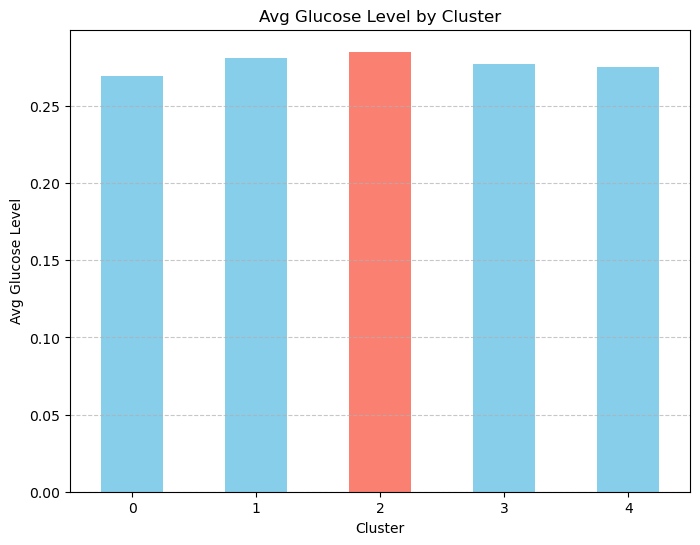

In [81]:
import matplotlib.pyplot as plt

# Identify the cluster with the highest avg_glucose_level
highest_cluster = cluster_means['avg_glucose_level'].idxmax()

# Create a color array: skyblue for all bars, and a different color for the highest
colors = ['skyblue' if idx != highest_cluster else 'salmon' for idx in cluster_means.index]

# Plot bar chart with the highlighted bar
plt.figure(figsize=(8, 6))
cluster_means['avg_glucose_level'].plot(kind='bar', color=colors)
plt.title('Avg Glucose Level by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg Glucose Level')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [82]:
# Group by Cluster and calculate means
cluster_means = df.groupby('Cluster').mean()

# Extract smoking and work type columns
smoking_work_means = cluster_means[[
    'smoking_status_Unknown',
    'smoking_status_formerly smoked', 
    'smoking_status_never smoked', 
    'smoking_status_smokes',
    'work_type_Govt_job',
    'work_type_Never_worked',
    'work_type_Private',
    'work_type_Self-employed',
    'work_type_children'
]]

# Preview the data
print(smoking_work_means)


         smoking_status_Unknown  smoking_status_formerly smoked  \
Cluster                                                           
0                      0.899007                        0.018212   
1                      0.000000                        0.000000   
2                      0.115163                        0.242802   
3                      1.000000                        0.000000   
4                      0.000000                        0.481657   

         smoking_status_never smoked  smoking_status_smokes  \
Cluster                                                       
0                           0.081126               0.001656   
1                           1.000000               0.000000   
2                           0.467370               0.174664   
3                           0.000000               0.000000   
4                           0.000000               0.518343   

         work_type_Govt_job  work_type_Never_worked  work_type_Private  \
Cluster       

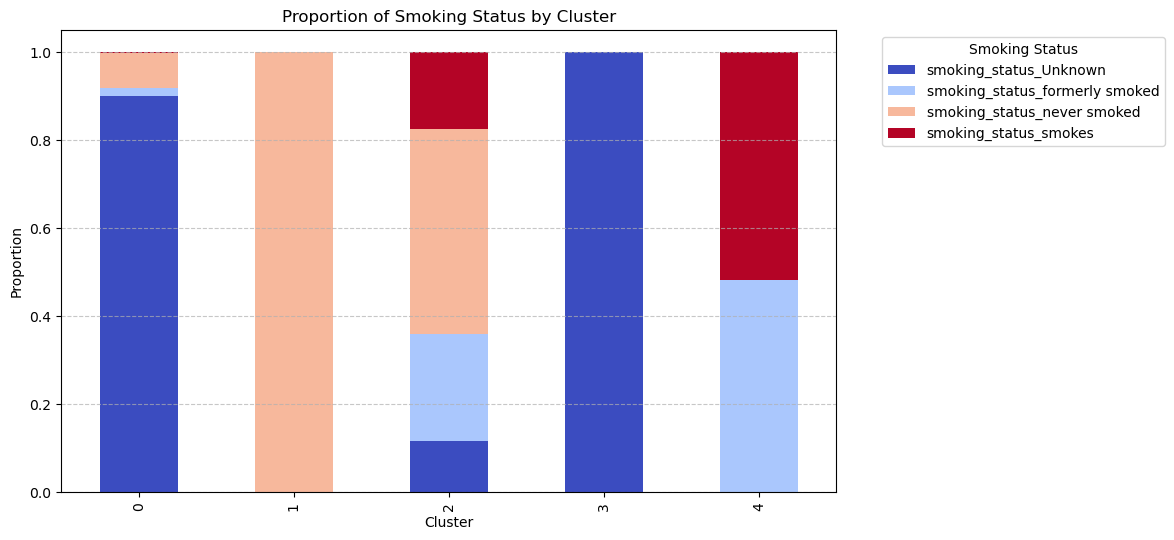

In [83]:
import matplotlib.pyplot as plt

# Smoking status proportions by cluster
smoking_means = smoking_work_means[['smoking_status_Unknown','smoking_status_formerly smoked', 
                                    'smoking_status_never smoked', 
                                    'smoking_status_smokes']]

# Plot stacked bar chart
smoking_means.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
plt.title('Proportion of Smoking Status by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Smoking Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


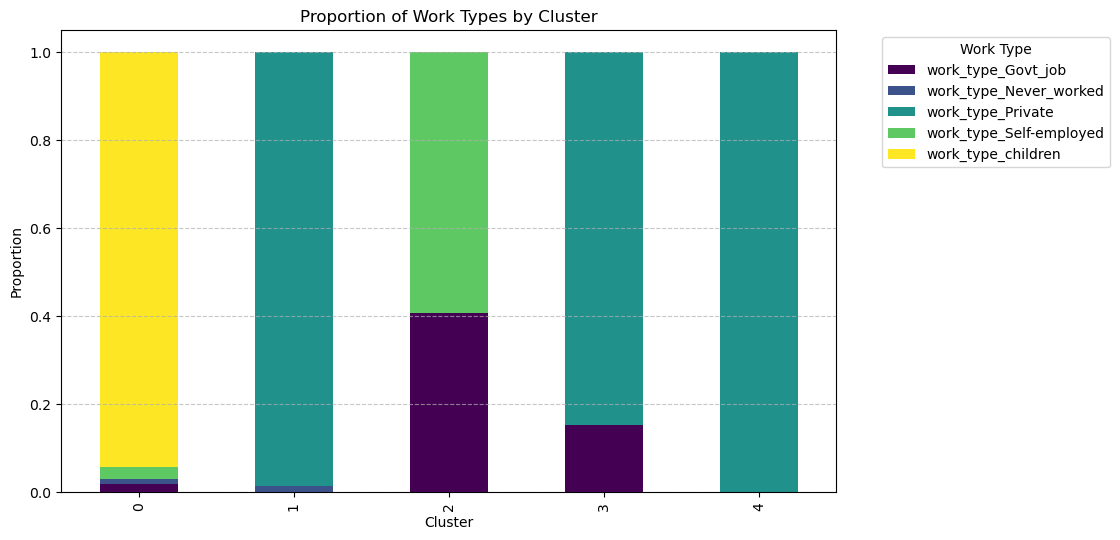

In [84]:
# Work type proportions by cluster
work_type_means = smoking_work_means[['work_type_Govt_job','work_type_Never_worked', 
                                      'work_type_Private', 
                                      'work_type_Self-employed', 
                                      'work_type_children']]

# Plot stacked bar chart
work_type_means.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
plt.title('Proportion of Work Types by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Work Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


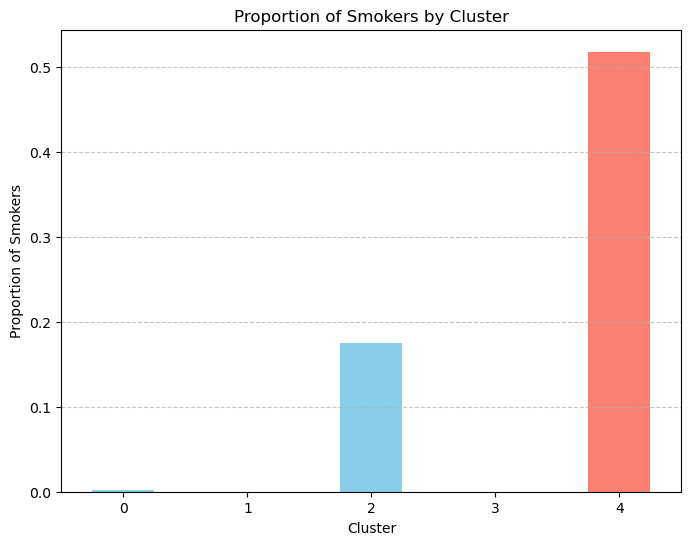

In [85]:
# Find the cluster with the highest proportion of smokers
highest_smoking_cluster = smoking_work_means['smoking_status_smokes'].idxmax()

# Highlight in bar chart
colors = ['salmon' if idx == highest_smoking_cluster else 'skyblue' for idx in smoking_work_means.index]

# Plot for smokers
plt.figure(figsize=(8, 6))
smoking_work_means['smoking_status_smokes'].plot(kind='bar', color=colors)
plt.title('Proportion of Smokers by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Smokers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


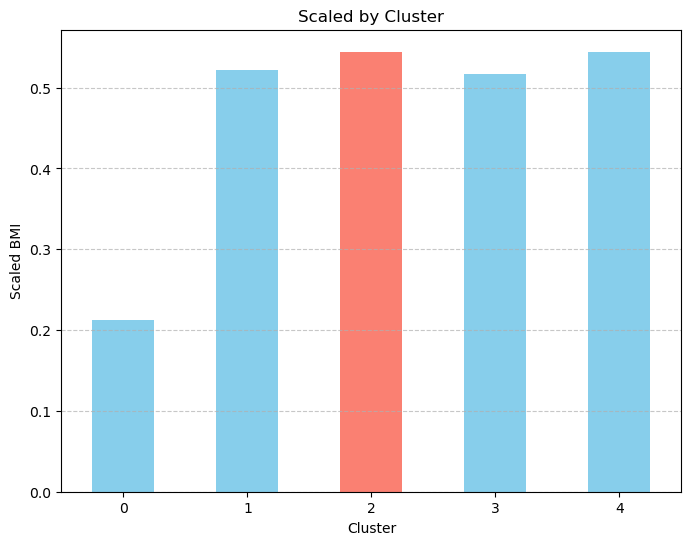

In [86]:
import matplotlib.pyplot as plt

# Identify the cluster with the highest avg_glucose_level
highest_bmi = cluster_means['bmi'].idxmax()

# Create a color array: skyblue for all bars, and a different color for the highest
colors = ['skyblue' if idx != highest_bmi else 'salmon' for idx in cluster_means.index]

# Plot bar chart with the highlighted bar
plt.figure(figsize=(8, 6))
cluster_means['bmi'].plot(kind='bar', color=colors)
plt.title('Scaled by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Scaled BMI')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


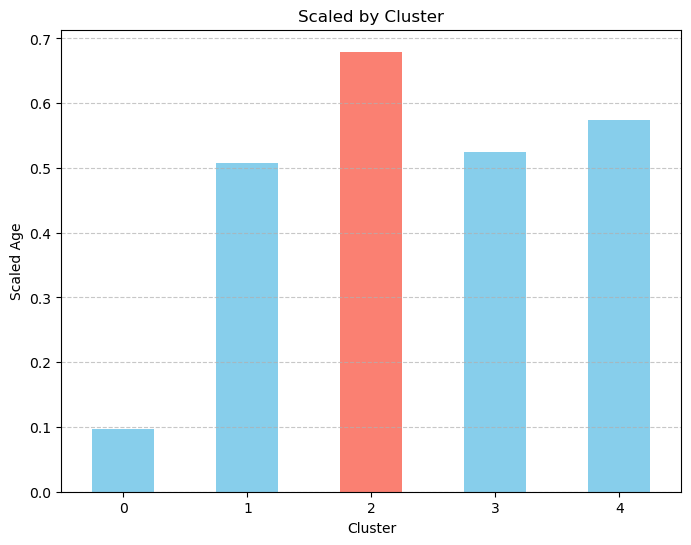

In [87]:
import matplotlib.pyplot as plt

# Identify the cluster with the highest avg_glucose_level
highest_age = cluster_means['age'].idxmax()

# Create a color array: skyblue for all bars, and a different color for the highest
colors = ['skyblue' if idx != highest_age else 'salmon' for idx in cluster_means.index]

# Plot bar chart with the highlighted bar
plt.figure(figsize=(8, 6))
cluster_means['age'].plot(kind='bar', color=colors)
plt.title('Scaled by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Scaled Age')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Cluster 4:
Majority of the individuals in this cluster are smokers and formely smoked. Health risk at obesity-related conditions and smoking-associated diseases.
Dominantly private-sector workers.



## Cluster 3:
Moderate BMI and glucose levels. Dominant by Unknown smoking status.





## Cluster 2:
Cluster 2 is distinct, representing self-employed individuals. It has highest BMI and Avg Glucose level. The age is also highest at all. This cluster might represent Older individuals, possibly seniors, with higher health risks especially diabetes and obesity.


## Cluster 1:
Predominated by private-sector workers.
Moderate BMI and glucose levels.This cluster show hihgest proportion of never smoked.



## Cluster 0:
Key Characteristics:
Predominantly children. It has lowest bmi and glucose level. 

This cluster likely represents younger individuals, likely children or teenagers with lower health risks and minimal workforce participation.